In [1]:
# the aim is to end up with train, test, evaluate
import sys
sys.path.append("/Users/david/Documents/code/fhmm/v1")

In [5]:
import src.ads_davidjames9610.ads as ads
# import src.ads_davidjames9610.useful as useful
import numpy as np
import os
import os.path
from pathlib import Path
import matplotlib.pyplot as plt
from importlib import reload
import importlib
import src.classifiers_davidjames9610.test_a.config as base_config
reload(base_config)
config = importlib.import_module('src.classifiers_davidjames9610.test_a.whale_data.config')
reload(config)
print(config.basedir)
# import src.misc_davidjames9610.fe_methods as fe
# import src.misc_davidjames9610.proc_methods as pm

/Users/david/Documents/code/fhmm/v1/src/classifiers_davidjames9610/test_a/whale_data


In [6]:
import src.misc_davidjames9610.utils as utils
sls = utils.load_pickle(config.samples_labels)

In [8]:
# # going to have to do fe after cross-validation split
# import src.misc_davidjames9610.cross_validation as cv
# from src.misc_davidjames9610.cross_validation import *
import importlib
# importlib.reload(cv)
# from src.classifiers_davidjames9610.test_a import b_samples_to_features as feat_proc
# reload(feat_proc)
import src.misc_davidjames9610.noisey as noisey
reload(noisey)
import random

In [9]:
test_signals = utils.load_pickle(r'/Users/david/Documents/code/fhmm/v1/src/hmm_annots_davidjames9610/test_signals.pickle')

test_features = test_signals['test_features']
test_labels = test_signals['test_labels']
train_features = test_signals['train_features']
train_labels = test_signals['train_labels']
label_set = test_signals['label_set']
noise_sample_a = test_signals['noise_sample_a']
noise_sample_a_features = test_signals['noise_sample_a_features']
noise_sample_b = test_signals['noise_sample_b']

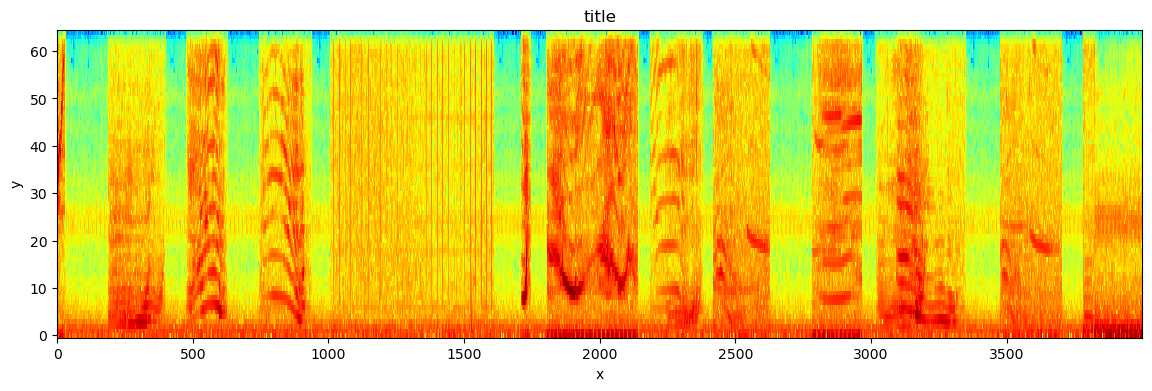

In [22]:
start_index = 11000
end_index = 15000
from spafe.utils import vis
vis.show_features(feats=test_features[start_index:end_index], title='title', ylabel='y', xlabel='x')
# plt.plot(test_labels[start_index:end_index])

In [23]:
# train classifier
from hmmlearn.hmm import GaussianHMM
import src.misc_davidjames9610.decode_combine as dc
import src.fhmm_davidjames9610.fhmm as fhmm
reload(fhmm)

curr_features = train_features
curr_labels = train_labels
n_components = 8
# classifiers = {}
base_classifiers = {}

for speaker in label_set:
    print('training for speaker: ', speaker)
    mask = (np.array(curr_labels) == speaker)
    mask = mask.tolist()
    speaker_features = [array for array, flag in zip(curr_features, mask) if flag]
    speaker_features = np.array([item for sublist in speaker_features for item in sublist])

    curr_classifier = GaussianHMM(n_components=n_components, covariance_type='diag')
    curr_classifier.fit(speaker_features)

    base_classifiers[speaker] = curr_classifier

#     fhmm_classifier = fhmm.FHMM(curr_classifier.n_components, n_components_b=3)
#     fhmm_classifier.fit_given_signal_hmm(curr_classifier, noise_sample_a)
# #
#     classifiers[speaker] = fhmm_classifier
#
# noise_hmm = GaussianHMM(n_components=4, covariance_type='diag')
# noise_hmm.fit(noise_sample_a_features)
#
# classifiers_to_combine = [classifiers[speaker_key].hmm_combined for speaker_key in
#                                                   classifiers]
# classifiers_to_combine.append(noise_hmm)


training for speaker:  0
training for speaker:  1
training for speaker:  2
training for speaker:  3
training for speaker:  4


In [24]:
import na_hmm as na_hmm
reload(na_hmm)

my_na_hmm = na_hmm.NoiseAdaptiveHMM(
    base_classifiers=base_classifiers,
    noise_features=noise_sample_a_features,
    label_set=label_set,
    noise_hmm_components=4
)

init noise adaptive hmm


In [25]:

_, predicted_labels, val_log_prob = my_na_hmm.dc_model.decode_hmmlearn(test_features[start_index:end_index])
performance_metrics = utils.get_performance_metrics(test_labels[start_index:end_index], predicted_labels, list(sls['num_to_label'].keys()))

print(performance_metrics['stats'])


{'precision': 0.9113656119278376, 'recall': 0.88775, 'f1-score': 0.8952046705731604, 'support': 4000, 'acc': 0.88775}


In [26]:
# Define sliding window parameters
import na_hmm as na_hmm
reload(na_hmm)

window_size = 200
step_size = 50
test_start_index = start_index
test_end_index = end_index

out = na_hmm.sliding_windows(
    data=test_features[test_start_index:test_end_index],
    window_size=window_size,
    step_size=step_size,
    na_hmm=my_na_hmm,
    mean_log_prob=-25000,
    threshold=1.2)

windows_states = out['states']

performance_metrics = utils.get_performance_metrics(test_labels[test_start_index:test_end_index], windows_states, list(sls['num_to_label'].keys()))

print(performance_metrics['stats'])

{'precision': 0.9111444446536489, 'recall': 0.8855, 'f1-score': 0.8939063073802863, 'support': 4000, 'acc': 0.8855}
